Pipeline for loading, creating and analyzing TCR graphs.

# Loading data

In [14]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

Load the data. can be csv/embedding.

In [15]:
df = pd.read_csv("./data_all_ab.csv")

Important note: healthy and sick samples originated from different patients.

In [16]:
# Filter rows where the first cell ends with "_OC"
filtered_OC = df[df.iloc[:, 0].str.endswith("_OC")]
# Filter rows where the first cell ends with "_H", with the same number of samples as OC
filtered_H = df[df.iloc[:, 0].str.endswith("_H")]
filtered_H = filtered_H.sample(n=len(filtered_OC), random_state=42)

In [17]:
def run_eda(og_df, threshold):
    non_zero_counts = og_df.astype(bool).sum()
    filtered_columns = non_zero_counts[non_zero_counts >= threshold].index
    filtered_df = og_df[filtered_columns]

In [18]:
# Compute the number of non-zero values in each column
non_zero_counts = filtered_H.astype(bool).sum()
threshold = 1
# Filter columns where at least n rows have a value in them
filtered_columns = non_zero_counts[non_zero_counts >= threshold].index
# Create a DataFrame with the filtered columns
filtered_df_H_4 = filtered_H[filtered_columns]

In [19]:
non_zero_counts = filtered_OC.astype(bool).sum()

threshold = 1
filtered_columns = non_zero_counts[non_zero_counts >= threshold].index
filtered_df_OC_4 = filtered_OC[filtered_columns]

In [20]:
# first column i "Unnamed:0", should be removed
columns_H_4 = filtered_df_H_4.columns[1:].tolist()
columns_OC_4 = filtered_df_OC_4.columns[1:].tolist()

## Creating the Graphs

In [21]:
from collections import defaultdict
from itertools import combinations
import networkx as nx
import pandas as pd
import tqdm

In [22]:
# function to group sequences by their lengths
def group_sequences_by_length(sequences):
    result = {}
    for seq in sequences:
        key = len(seq)
        if key not in result:
            result[key] = set()
        result[key].add(seq)
    # Convert the sets to tuples for immutable groups
    return {k: tuple(v) for k, v in result.items()}

def generate_hashed_substrings(sequence):
    # Generate all (length-1) substrings of the current sequence and hash them
    for substring in combinations(sequence, len(sequence) - 1):
        yield hash(substring), sequence

def edit_dist_one(tcr_sequences):
     # tcr_sequences is a list.
    # Filter out invalid sequences (non-string or length <= 1)
    valid_sequences = filter(lambda s: isinstance(s, str) and len(s) > 1, tcr_sequences)
    # Group sequences by their lengths
    sequences = group_sequences_by_length(valid_sequences)
    write_edge_list_bar = tqdm.tqdm(total=sum(len(s) * l for l, s in sequences.items()), desc="Writing pairs")
    edge_list = []
    for current_length in sorted(sequences.keys(), reverse=True):
        sequences_of_current_length = tuple(map(generate_hashed_substrings, sequences[current_length]))
        sequences_of_following_length = []
        if current_length - 1 in sequences.keys():
            sequences_of_following_length = tuple(map(lambda s: hash(tuple(s)), sequences[current_length - 1]))

        for i in range(current_length - 1, -1, -1):
            # Create a dictionary to store sequences grouped by their hashed subsequences
            sequences_by_hashed_substrings = defaultdict(list)

            for hashed_subsequence, sequence in map(next, sequences_of_current_length):
                sequences_by_hashed_substrings[hashed_subsequence].append(sequence)

            # If sequences of following length exist, add them to the dictionary as indel sequences
            if current_length - 1 in sequences.keys():
                for index, hashed_sequence in enumerate(sequences_of_following_length):
                    if hashed_sequence in sequences_by_hashed_substrings:
                        sequences_by_hashed_substrings[hashed_sequence].append(sequences[current_length - 1][index])

            # Filter out groups with only one sequence
            sequences_by_hashed_substrings = [v for k, v in sequences_by_hashed_substrings.items() if len(v) > 1]

            for group in sequences_by_hashed_substrings:  # Sort sequences and generate edges
                if current_length - 1 in sequences.keys() and len(group[-1]) == current_length - 1:
                    group[:-1] = sorted(group[:-1])
                    edge_list.extend(combinations(group[:-1], 2))
                    edge_list.extend([(s, group[-1]) for s in group[:-1] if i == 0 or (i > 0 and s[i] != s[i - 1])])
                else:
                    group = sorted(group)
                    edge_list.extend(combinations(group, 2))

            write_edge_list_bar.update(len(sequences[current_length]))
        sequences.pop(current_length)
    write_edge_list_bar.close()
    # Convert the edge list to a list of tuples
    edge_list = list(edge_list)
    edge_df = pd.DataFrame(edge_list, columns=["Seq1", "Seq2"])
    print(f"Edge list - Done.")
    return edge_df


In [23]:
def draw_graph(edge_list):
    # edge list should be pd df, with 2 columns: Seq1, Seq2
    G = nx.Graph()
    for _, row in edge_list.iterrows():
        source = row['Seq1']
        target = row['Seq2']
        G.add_edge(source, target)
    print("Done adding edges.")
    # Step 5: Adjust plot parameters
    plt.figure(figsize=(12, 8))  # Set the figure size
    nx.draw(G, with_labels=False, node_size=10)  # Adjust node_size

    plt.show()
    return G

In [24]:
edge_list_H1 = edit_dist_one(columns_H_4)
edge_list_H1.to_csv("./outputs/edge_lists/edge_list_1_H.csv")

edge_list_OC_1 = edit_dist_one(columns_OC_4)
edge_list_OC_1.to_csv("./outputs/edge_lists/edge_list_1_OC.csv")

Writing pairs: 100%|██████████| 7105060/7105060 [00:16<00:00, 425788.55it/s]


Edge list - Done.


Writing pairs: 100%|██████████| 7167682/7167682 [00:17<00:00, 416307.39it/s]


Edge list - Done.


Writing pairs:   0%|          | 0/91472 [00:00<?, ?it/s]

Writing pairs: 100%|██████████| 91472/91472 [00:00<00:00, 1425958.91it/s]


Edge list - Done.
Done adding edges.


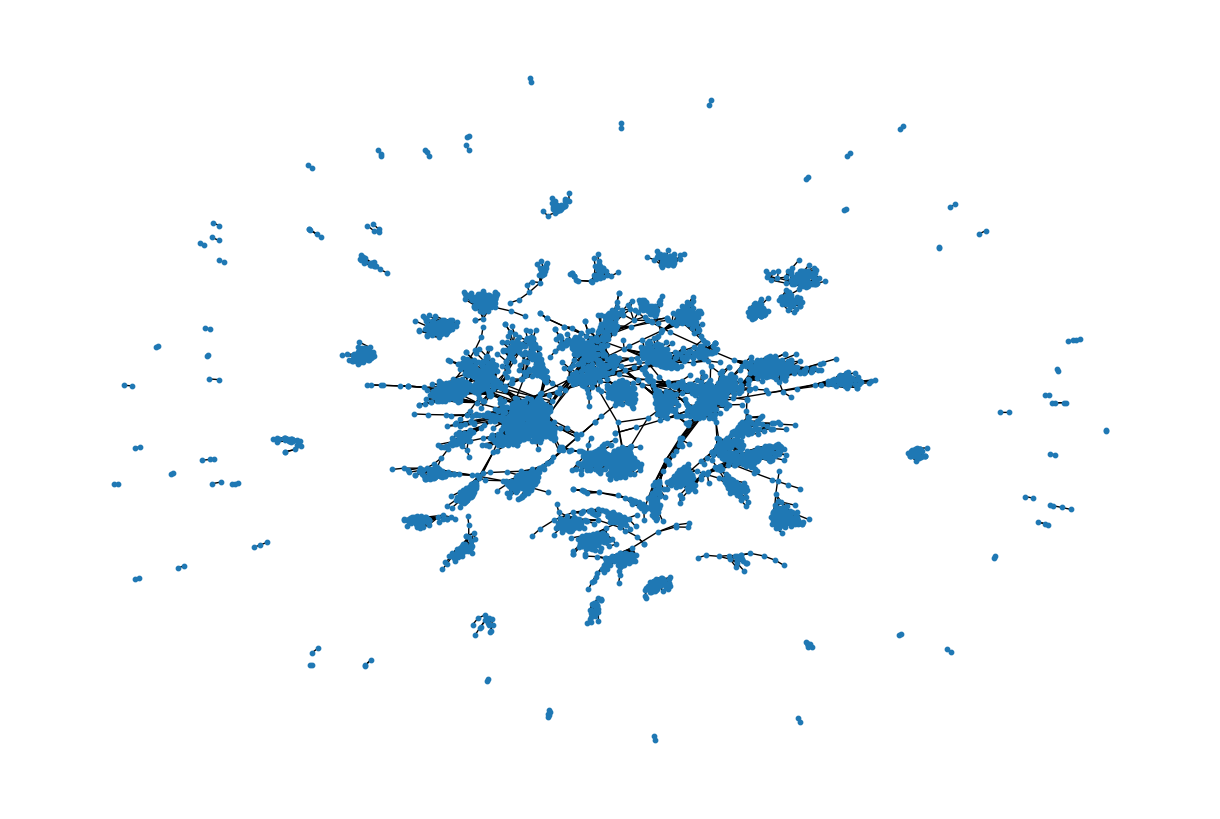

In [11]:
edge_list_H_4 = edit_dist_one(columns_H_4)
H_4_graph = draw_graph(edge_list_H_4)

Writing pairs: 100%|██████████| 69177/69177 [00:00<00:00, 1415659.71it/s]


Edge list - Done.
Done adding edges.


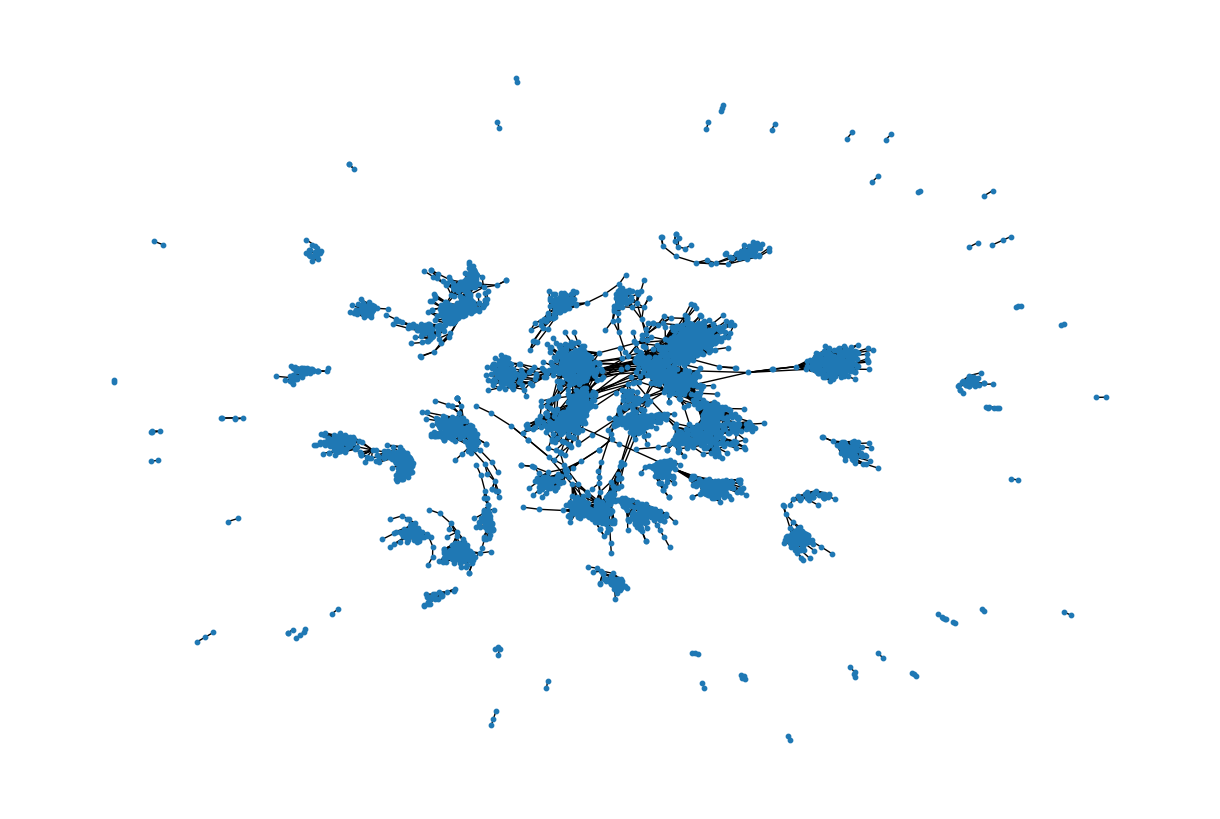

In [12]:
edge_list_OC_4 = edit_dist_one(columns_OC_4)
OC_4_graph = draw_graph(edge_list_OC_4)

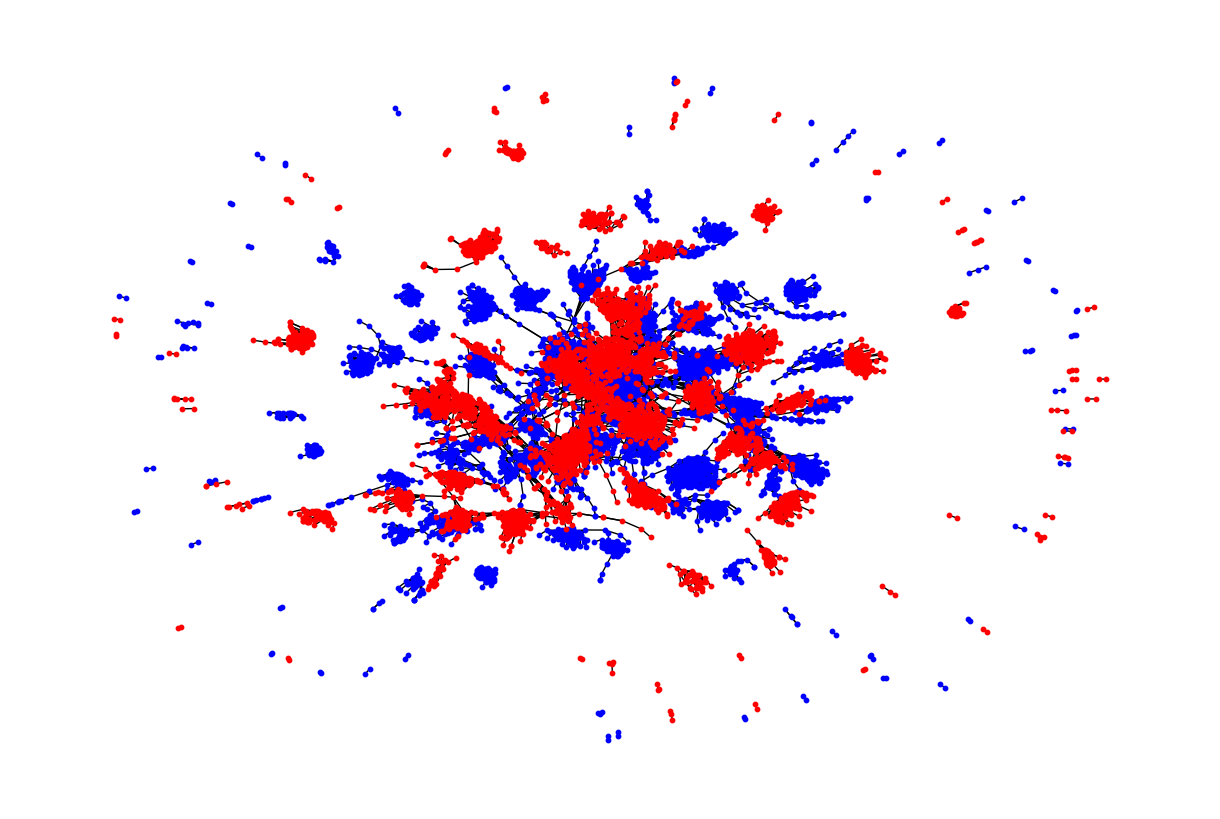

In [13]:
# Adjust plot parameters
plt.figure(figsize=(12, 8))  # Set the figure size

# Draw H_4_graph in blue color
nx.draw(H_4_graph, with_labels=False, node_size=10, node_color='blue')

# Draw OC_4_graph in red color
nx.draw(OC_4_graph, with_labels=False, node_size=10, node_color='red')

# Show the plot
plt.show()

## Exploring the graphs

In [14]:
def basic_graph_stats(G):
    print(f"The number of nodes in graph is: {G.number_of_nodes()}. The number of edges is: {G.number_of_edges()}")
    print(f"average node degree is: {np.mean([d for _, d in G.degree])}")
    print(f"Graph density is:{nx.density(G)}")
    print(f"Average clustering coefficient:{nx.average_clustering(G)}")
        # Check if the graph is connected before calculating diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter: {diameter}")
    else:
        print("Graph is not connected, cannot compute diameter.")


def visualize_graph(G):
    plt.figure(figsize=(18, 16))  # Increase figure size

    # Define node size based on degree
    degrees = dict(G.degree)
    node_size = [v * 10 for v in degrees.values()]  # Adjust multiplier as needed

    # Define edge width and color based on additional attributes if needed
    edge_color = [0.5 if 'weight' in data else 0 for _, _, data in G.edges(data=True)]
    edge_alpha = [0.1 if 'weight' in data else 0.5 for _, _, data in G.edges(data=True)]

    # Spring layout
    plt.subplot(2, 2, 1)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=node_size, edge_color=edge_color, alpha=edge_alpha)
    plt.title("Spring Layout")

    # Circular layout
    plt.subplot(2, 2, 2)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=node_size, edge_color=edge_color, alpha=edge_alpha)
    plt.title("Circular Layout")

    # Kamada-Kawai layout
    plt.subplot(2, 2, 3)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=node_size, edge_color=edge_color, alpha=edge_alpha)
    plt.title("Kamada-Kawai Layout")

    plt.tight_layout()
    plt.show()

def centrality_community_measures(G):
    # Calculate degree centrality for graph
    degree_centrality = nx.degree_centrality(G)
    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    top_10_degree_centrality = sorted_degree_centrality[:10]
    # Calculate betweenness centrality for graph
    betweenness_centrality = nx.betweenness_centrality(G)
    sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

    # Print top 10 most influential nodes based on degree centrality for H4
    print("Top 10 most influential nodes based on degree centrality:")
    for node, centrality in top_10_degree_centrality:
        print(f"Node: {node}, Degree centrality: {centrality}")

    # Print top 10 most influential nodes based on betweenness centrality for H4
    print("\nTop 10 most influential nodes based on betweenness centrality:")
    for node, centrality in top_10_betweenness_centrality:
        print(f"Node: {node}, Betweenness centrality: {centrality}")

    ## Comunnities
    communities = nx.algorithms.community.greedy_modularity_communities(G)
    # Calculate the sizes of each community
    community_sizes = [(communities, len(nodes)) for community, nodes in enumerate(communities, start=1)]
    total_comm_size = sum(size for _, size in community_sizes)
    print (f"Average community size is: {total_comm_size / len(community_sizes)}")
    if (len(community_sizes) < 50):
        # Sort the communities by size in descending order
        sorted_community_sizes = sorted(community_sizes, key=lambda x: x[1], reverse=True)

        # Print the sizes of the communities ordered by size
        print("Sizes of communities ordered by size:")
        for i, (community, size) in enumerate(sorted_community_sizes, start=1):
            print(f"Community {i}: Size {size}")

    ## Connected components
    # Determine the number of connected components
    print("Number of connected components in graph:", nx.number_connected_components(G))
    # Get the 10 largest connected components from H_4_graph and OC_4_graph
    largest_connected = sorted(nx.connected_components(G), key=len, reverse=True)[:10]
    connected_graph = nx.Graph()
    # Add nodes and edges from the 10 largest connected components to the graph
    for component in largest_connected:
        connected_graph.add_nodes_from(component)
        connected_graph.add_edges_from(G.subgraph(component).edges())

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(connected_graph)
    nx.draw(connected_graph, pos, node_color='red', with_labels=False, node_size=10)
    plt.title("Visualization of the 10 Largest Connected Components")  
    plt.show()

def path_analysis(G):
    # Shortest paths
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

    # Calculate average shortest path length
    total_shortest_paths = sum(sum(length for length in lengths.values()) for lengths in shortest_paths.values())
    num_pairs = sum(len(lengths) for lengths in shortest_paths.values())
    avg_shortest_path_length = total_shortest_paths / num_pairs

    print("Average shortest path length:", avg_shortest_path_length)

    # Path length distribution
    path_lengths = [length for lengths in shortest_paths.values() for length in lengths.values()]

    plt.hist(path_lengths, bins=max(path_lengths)+1, alpha=0.7)
    plt.title("Path Length Distribution")
    plt.xlabel("Path Length")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def assortativity_analysis(G):
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    attribute_assortativity = nx.attribute_assortativity_coefficient(G, 'attribute_name')

    print("Degree Assortativity Coefficient:", degree_assortativity)
    print("Attribute Assortativity Coefficient:", attribute_assortativity)

def subgraph_analysis(G):
    # Identify and analyze subgraphs
    components = list(nx.connected_components(G))
    subgraphs = [G.subgraph(c).copy() for c in components]
    num_subgraphs = len(subgraphs)

    print("Number of subgraphs:", num_subgraphs)

    # Visualize the largest subgraph
    largest_subgraph = max(subgraphs, key=len)
    plt.figure(figsize=(8, 6))
    nx.draw(largest_subgraph, with_labels=True, node_color='skyblue', edge_color='#BBBBBB', font_size=8)
    plt.title("Largest Subgraph Visualization")
    plt.show()

def graph_algorithms(G):
    # Since G is a graph object, the algorithm applied should correspond to the graph type (directed/undirected)
    print("Traversal Order:", list(nx.dfs_preorder_nodes(G)))
    print("Breadth-First Search Tree Edges:", list(nx.bfs_tree(G, source=list(G.nodes())[0]).edges()))
    print("Minimum Spanning Tree Edges:", list(nx.minimum_spanning_tree(G).edges()))
    print("Strongly Connected Components:", list(nx.strongly_connected_components(G)))
    print("Weakly Connected Components:", list(nx.weakly_connected_components(G)))
    print("Articulation Points:", list(nx.articulation_points(G)))
    print("Bridges:", list(nx.bridges(G)))



In [15]:
def eda_graph(G):
    basic_graph_stats(G)
    centrality_community_measures(G)
    path_analysis(G)
    assortativity_analysis(G)
    subgraph_analysis(G)
    graph_algorithms(G)
    visualize_graph(G)

The number of nodes in graph is: 6655. The number of edges is: 27341
average node degree is: 8.216679188580015
Graph density is:0.0012348480896573512
Average clustering coefficient:0.46382856343503237
Graph is not connected, cannot compute diameter.


Top 10 most influential nodes based on degree centrality:
Node: CASSLGYEQYF, Degree centrality: 0.0069131349564171924
Node: CAASNTGNQFYF, Degree centrality: 0.0066125638713555755
Node: CAASTGNQFYF, Degree centrality: 0.0063119927862939585
Node: CASSLGGNTEAFF, Degree centrality: 0.00616170724376315
Node: CAVSNDYKLSF, Degree centrality: 0.00616170724376315
Node: CAVNTGNQFYF, Degree centrality: 0.00616170724376315
Node: CASSLGGYEQYF, Degree centrality: 0.006011421701232341
Node: CAVTSGTYKYIF, Degree centrality: 0.005861136158701532
Node: CAVNAGGTSYGKLTF, Degree centrality: 0.005560565073639915
Node: CASSLGSYEQYF, Degree centrality: 0.005560565073639915

Top 10 most influential nodes based on betweenness centrality:
Node: CASSLGGEQYF, Betweenness centrality: 0.016814965515136594
Node: CASSLGGEQFF, Betweenness centrality: 0.016359943904878844
Node: CASSLGGGEAFF, Betweenness centrality: 0.012158056502487306
Node: CASSLGGGEQFF, Betweenness centrality: 0.011909580912481725
Node: CASSLGYEQYF, B

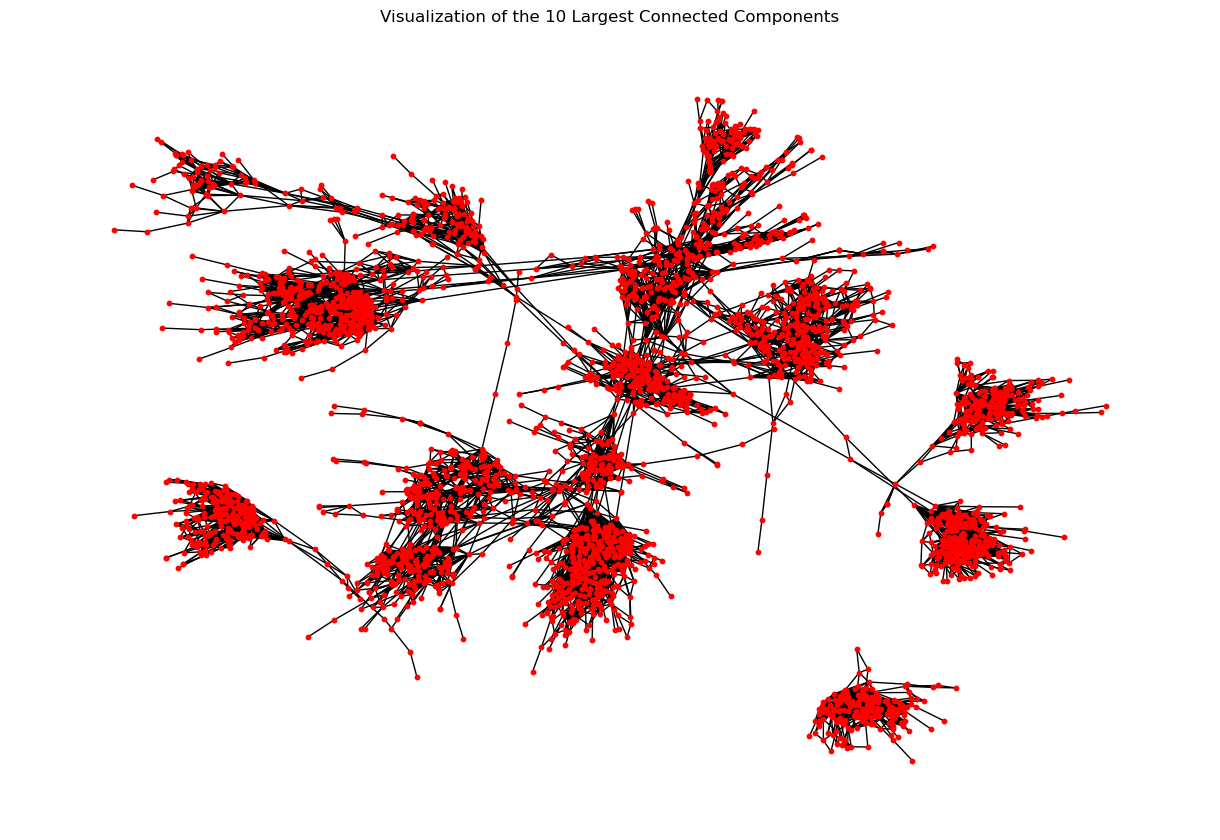

Average shortest path length: 6.293875357175904


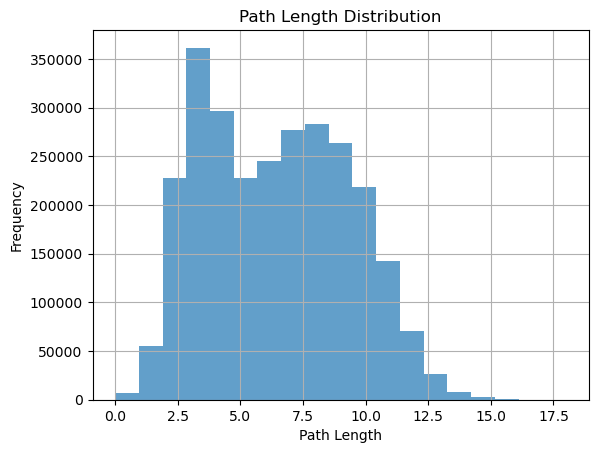

/home/dsi/orrbavly/anaconda3/envs/deep/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:278: RuntimeWarning: invalid value encountered in double_scalars
  r = (t - s) / (1 - s)


Degree Assortativity Coefficient: 0.2748730056542728
Attribute Assortativity Coefficient: nan
Number of subgraphs: 108


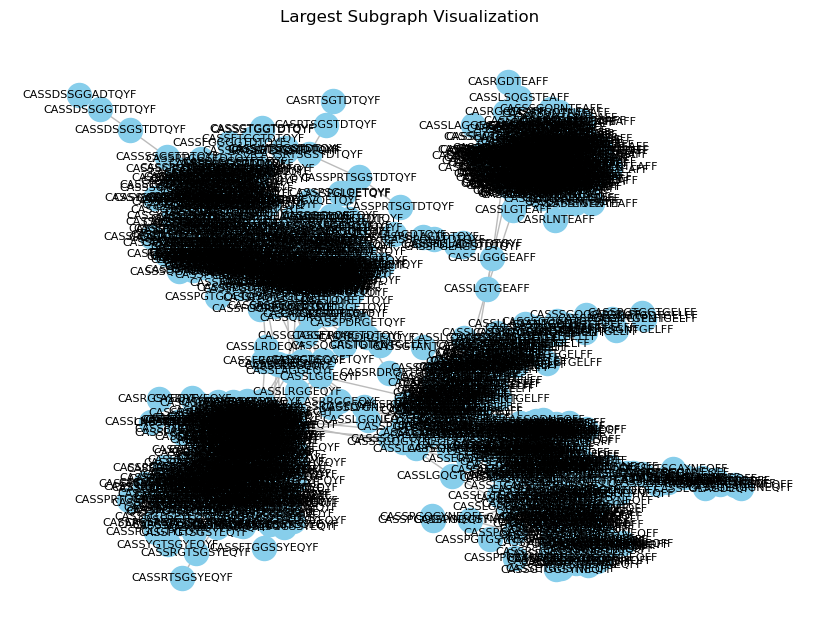

Traversal Order: ['CAYRSADAGGTSYGKLTF', 'CAYRSAGAGGTSYGKLTF', 'CAYRSANAGGTSYGKLTF', 'CAYRSAYAGGTSYGKLTF', 'CAYRSGAGGTSYGKLTF', 'CAYRSDAGGTSYGKLTF', 'CAYRSSAGGTSYGKLTF', 'CAYRSAGGTSYGKLTF', 'CAYRNAGGTSYGKLTF', 'CAYRRNAGGTSYGKLTF', 'CAYSNAGGTSYGKLTF', 'CAYNAGGTSYGKLTF', 'CAVYNAGGTSYGKLTF', 'CAVANAGGTSYGKLTF', 'CAVQANAGGTSYGKLTF', 'CAVAAGGTSYGKLTF', 'CAVDAGGTSYGKLTF', 'CAVRDAGGTSYGKLTF', 'CAVRGAGGTSYGKLTF', 'CAVRGGGTSYGKLTF', 'CAVRAGGTSYGKLTF', 'CAVRNAGGTSYGKLTF', 'CAVRRAGGTSYGKLTF', 'CAVRYAGGTSYGKLTF', 'CAVGNAGGTSYGKLTF', 'CAVGTNAGGTSYGKLTF', 'CAVTNAGGTSYGKLTF', 'CAVINAGGTSYGKLTF', 'CAVKNAGGTSYGKLTF', 'CAVKGAGGTSYGKLTF', 'CAVKAGGTSYGKLTF', 'CAVEAGGTSYGKLTF', 'CAVEGGTSYGKLTF', 'CAVSEGGTSYGKLTF', 'CAVSAGGTSYGKLTF', 'CAVSDAGGTSYGKLTF', 'CAVSFAGGTSYGKLTF', 'CAVSNAGGTSYGKLTF', 'CAVSLNAGGTSYGKLTF', 'CAVLNAGGTSYGKLTF', 'CAVLAGGTSYGKLTF', 'CAVGAGGTSYGKLTF', 'CAVGGGTSYGKLTF', 'CAVSGGGTSYGKLTF', 'CAVSSGGTSYGKLTF', 'CAVSSAGGTSYGKLTF', 'CAASSAGGTSYGKLTF', 'CAASSNAGGTSYGKLTF', 'CAASANAGGTSYGKLTF', 'C

NetworkXNotImplemented: not implemented for undirected type

In [16]:
eda_graph(H_4_graph)

The number of nodes in graph is: 5043. The number of edges is: 20015
average node degree is: 7.9377354749157245
Graph density is:0.0015743227836008975
Average clustering coefficient:0.4495643957302176
Graph is not connected, cannot compute diameter.
Top 10 most influential nodes based on degree centrality:
Node: CASSLGYEQYF, Degree centrality: 0.009916699722332408
Node: CASSLGGNTEAFF, Degree centrality: 0.009520031733439112
Node: CASSLGSYEQYF, Degree centrality: 0.008925029750099168
Node: CASSLGTDTQYF, Degree centrality: 0.00872669575565252
Node: CAASNTGNQFYF, Degree centrality: 0.00852836176120587
Node: CASSLGGYEQYF, Degree centrality: 0.008330027766759222
Node: CASSLGNTEAFF, Degree centrality: 0.008131693772312574
Node: CASSLGGTDTQYF, Degree centrality: 0.007735025783419278
Node: CASSLSYEQYF, Degree centrality: 0.007735025783419278
Node: CASSLGETQYF, Degree centrality: 0.007735025783419278

Top 10 most influential nodes based on betweenness centrality:
Node: CASSLGGEQFF, Betweenness 

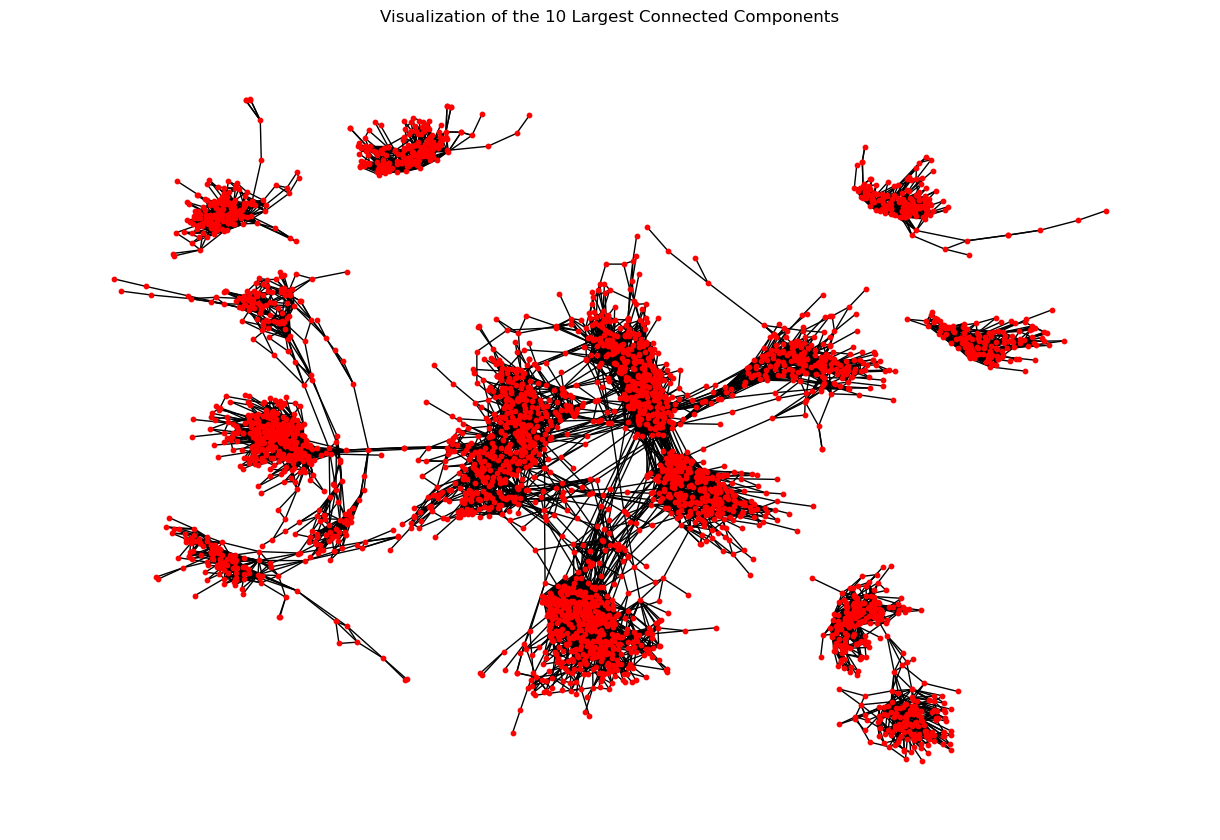

Average shortest path length: 7.013350105603887


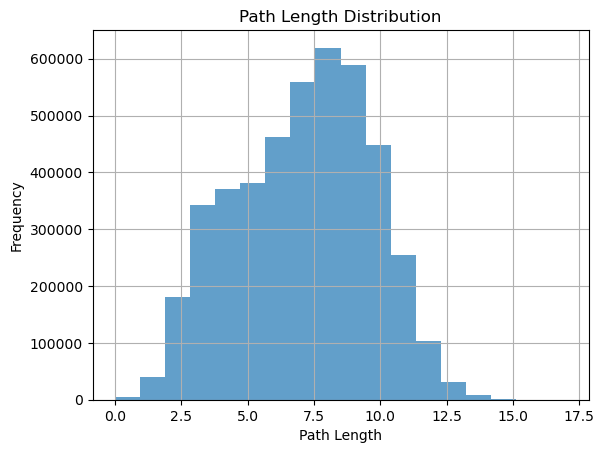

Degree Assortativity Coefficient: 0.26078958278907827
Attribute Assortativity Coefficient: nan
Number of subgraphs: 76


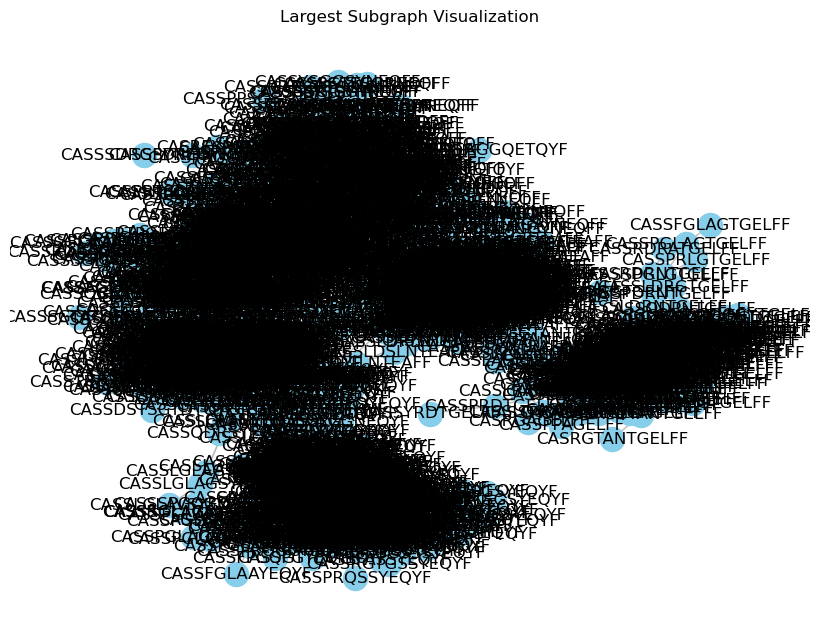

Traversal Order: ['CAYRSADAGGTSYGKLTF', 'CAYRSAKAGGTSYGKLTF', 'CAYRSAGYGGSQGNLIF', 'CAYRSANYGGSQGNLIF', 'CAYRSARYGGSQGNLIF', 'CAASARNSGGSNYKLTF', 'CAASARSGGSNYKLTF', 'CAASASGGSNYKLTF', 'CAASAGGGSNYKLTF', 'CAASEGGGSNYKLTF', 'CAASESGGSNYKLTF', 'CAASDSGGSNYKLTF', 'CAASDGGSNYKLTF', 'CAASGGGSNYKLTF', 'CAASGSGGSNYKLTF', 'CAASGRSGGSNYKLTF', 'CAASRSGGSNYKLTF', 'CAASRGSGGSNYKLTF', 'CAASRGGGSNYKLTF', 'CAASRGGSNYKLTF', 'CAASIRGGSNYKLTF', 'CAASIGGGSNYKLTF', 'CAASIGSGGSNYKLTF', 'CAASKGSGGSNYKLTF', 'CAASKGGGSNYKLTF', 'CAASSGGSNYKLTF', 'CAASNSGGSNYKLTF', 'CAASPNSGGSNYKLTF', 'CAASRNSGGSNYKLTF', 'CAARNSGGSNYKLTF', 'CAARGNSGGSNYKLTF', 'CAARGSGGSNYKLTF', 'CAARDSGGSNYKLTF', 'CAARSGGSNYKLTF', 'CAARGGSNYKLTF', 'CAGARGGSNYKLTF', 'CAGARGSNYKLTF', 'CAGAGGSNYKLTF', 'CAGRGGSNYKLTF', 'CAGRSGGSNYKLTF', 'CAGRNSGGSNYKLTF', 'CAGLNSGGSNYKLTF', 'CAGPNSGGSNYKLTF', 'CAGPGSGGSNYKLTF', 'CAGPSGGSNYKLTF', 'CAGDSGGSNYKLTF', 'CAGGSGGSNYKLTF', 'CAGVGSGGSNYKLTF', 'CAVGSGGSNYKLTF', 'CAVGNSGGSNYKLTF', 'CAVKNSGGSNYKLTF', 'CAVKGSGGS

NetworkXNotImplemented: not implemented for undirected type

In [ ]:
eda_graph(OC_4_graph)